In [1]:
import IGIMF
import numpy as np
import pandas as pd
from scipy import optimize
import scipy.integrate as integr

In [2]:
mass_metals: float = 1e7 # [Msun]
mass_gas: float = 1e9 # [Msun]
M_pgal: float = 1e10 # [Msun]
downsizing_time: float = 10 # [yr] 
t: float = 1 # [Gyr]

In [3]:
igimf = IGIMF.IGIMF(mass_metals, mass_gas, M_pgal, downsizing_time, t)

In [4]:
resolution = 50
M_ecl_v = np.logspace(np.log10(igimf.M_ecl_min), np.log10(igimf.M_ecl_max), num=resolution)
m_v = np.logspace(np.log10(igimf.m_star_min), np.log10(igimf.m_star_max), num=resolution)

In [5]:
k_ecl, M_max = igimf.normalization(igimf.embedded_cluster_mass_function, igimf.SFR * igimf.delta_t, igimf.M_ecl_min, igimf.M_ecl_max)

/Users/thecosmicweb/Documents/GitHub/IGIMF/_scratch/IGIMF.py:89: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  k = lambda x: np.reciprocal(integr.quad(IMF, x, upper_lim,
/Users/thecosmicweb/Documents/GitHub/IGIMF/_scratch/IGIMF.py:89: RuntimeWarning: divide by zero encountered in reciprocal
  k = lambda x: np.reciprocal(integr.quad(IMF, x, upper_lim,


In [6]:
#[igimf.embedded_cluster_mass_function(M) for M in M_ecl_v]
k_ecl, M_max, ECMF_func = igimf.ECMF()
ECMF_v = [M * ECMF_func(M) for M in M_ecl_v]
ECMF_integral = integr.simpson(ECMF_v, x=M_ecl_v) 
np.log10(np.abs(ECMF_integral- igimf.SFR * igimf.delta_t))


5.112576279932792

In [7]:
ECMF_integral

19870408.570674192

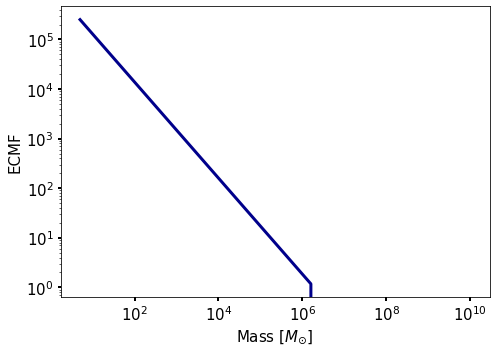

In [8]:
def IMF_plot(m_v, IMF_v, k, m_max, name : str, num_colors=1):
    from matplotlib import pyplot as plt
    import matplotlib.ticker as ticker
    cm = plt.cm.get_cmap(name='plasma')
    currentColors = [cm(1.*i/num_colors) for i in range(num_colors)]
    fig, ax = plt.subplots(1,1, figsize=(7,5))
    ax.loglog(m_v,IMF_v, linewidth=3, color='darkblue')
    ax.set_ylabel(name, fontsize=15)
    ax.set_xlabel(r'Mass $[M_{\odot}]$', fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    ax.tick_params(width=2)
    fig.tight_layout()
    plt.savefig(f'IMF_plot_{name}.pdf', bbox_inches='tight')
    #plt.show(block=False)
    return None
IMF_plot(M_ecl_v, ECMF_v, k_ecl, M_max, 'ECMF')

In [9]:
k_ecl, M_max, ECMF_func = igimf.ECMF()
sIMF_weighted = pd.DataFrame([igimf.stellar_IMF(M, ECMF_weight=ECMF_func(M))  for M in M_ecl_v], columns=['kstar', 'm_max', 'func'])
sIMF = pd.DataFrame([igimf.stellar_IMF(M)  for M in M_ecl_v], columns=['kstar', 'm_max', 'func'])
sIMF_func = sIMF['func'].values 

/Users/thecosmicweb/Documents/GitHub/IGIMF/_scratch/IGIMF.py:89: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  k = lambda x: np.reciprocal(integr.quad(IMF, x, upper_lim,
/Users/thecosmicweb/Documents/GitHub/IGIMF/_scratch/IGIMF.py:89: RuntimeWarning: divide by zero encountered in reciprocal
  k = lambda x: np.reciprocal(integr.quad(IMF, x, upper_lim,
/Users/thecosmicweb/Documents/GitHub/IGIMF/_scratch/IGIMF.py:102: RuntimeWarning: divide by zero encountered in reciprocal
  k = lambda x: np.reciprocal(integr.quad(IMF, x, upper_lim, args=(alpha_3,))[0])
/Users/thecosmicweb/Documents/GitHub/IGIMF/_scratch/IGIMF.py:102: RuntimeWarning: divide by zero encountered in reciprocal
  k = lambda x: np.reciprocal(integr.quad(IMF, x, upper_lim, args=(alpha_3,))[0])


In [10]:
def IMF_3D_plot(m_v, M_ecl_v, sIMF_func):
    from mpl_toolkits import mplot3d
    import matplotlib.pyplot as plt
    
    def z_func(m,M):
        return np.reshape([[sIMF_func[i](m_j) for m_j in m] for i,val in enumerate(M)], (len(m), len(M)))
    
    def resh(x):
        return np.reshape(list(x) * len(x), (len(x),len(x)))
    
    fig = plt.figure(figsize=(10,8))
    # syntax for 3-D projection
    ax = plt.axes(projection ='3d')
    m = resh(m_v)
    M = resh(M_ecl_v).T
    xi = z_func(m_v, M_ecl_v)
    
    # plotting
    #ax.plot3D(x, y, z, 'green')
    ax.plot_surface(np.log10(m), np.log10(M), np.ma.log10(xi), cmap ='plasma', linewidth=0.25)
    ax.set_xlabel(r'stellar mass $m_{\star}$ [$\log_{10}(M_{\odot})$]', fontsize=15)
    ax.set_ylabel(r'E. cluster mass $M_{\rm ecl}$ [$\log_{10}(M_{\odot})$]', fontsize=15)
    ax.set_zlabel(r'$\xi_{\star}={\rm d}N_{\star}/ {\rm d} m$', fontsize=15)
    ax.set_title(r'stellar IMF $\xi_{\star}(m_{\star},M_{\rm ecl},Z)$', fontsize=17)
    fig.tight_layout()
    plt.show(block=False)
    plt.savefig(f'IMF_plot_3D.pdf', bbox_inches='tight')
    
    print(f'\nFor every cluster mass, integrate the stellar IMF over the stellar mass range:\n')
    print([integr.simpson(xi[i],x=m_v) for i,_ in enumerate(M_ecl_v)])
    print(f'\nFor every cluster mass, the mass of the cluster will be:\n')
    print([integr.simpson([xi[i]* m for m in m_v],x=m_v) for i,_ in enumerate(M_ecl_v)])

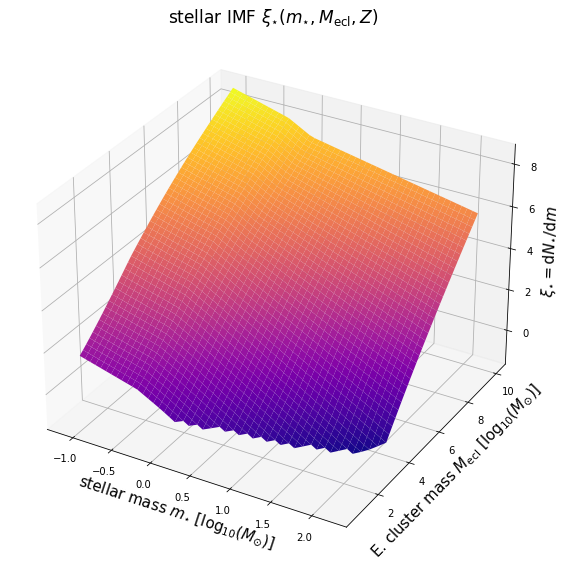


For every cluster mass, integrate the stellar IMF over the stellar mass range:

[12.536087156277585, 18.026966310118382, 26.0192148246041, 37.55358625609904, 54.88243544758927, 80.61561806875969, 119.01669555882167, 176.571376180367, 263.17450613567564, 393.966022329171, 591.9587053072416, 893.3529528543221, 1353.1292486857965, 2056.4262626389313, 3136.2324885675116, 4797.403376483172, 7239.805766335224, 10549.383264277798, 15328.950437591611, 22199.442727114263, 32026.355525625448, 46002.87647911351, 65765.1599679626, 93543.3653293122, 132360.37777974468, 186293.20198374565, 260817.32373315396, 363261.6195753819, 503411.68218349194, 694313.708984934, 953351.2123525834, 1303695.1283143132, 1776268.1534599862, 2412421.373455837, 3267603.669874075, 4416423.247328278, 5959673.3386682, 8034146.17709332, 10826428.94039035, 14592419.391605997, 19685102.909571636, 26594325.27600823, 36004066.67047799, 48875370.37079529, 66567029.95676814, 91012067.4231274, 124976932.98796752, 172443753.78964

<Figure size 432x288 with 0 Axes>

In [11]:
IMF_3D_plot(m_v, M_ecl_v, sIMF_func)